# NLP - Hotel review sentiment analysis

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px

import re
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [2]:
rivewdata=pd.read_csv('C:/Users/ameyh/Downloads/archive (1)/train.csv')

In [3]:
rivewdata.shape

(38932, 5)

In [4]:
rivewdata.head(10)

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy
5,id10331,We had - rooms. One was very nice and clearly ...,InternetExplorer,Desktop,happy
6,id10332,My husband and I have stayed in this hotel a f...,Firefox,Tablet,not happy
7,id10333,My wife & I stayed in this glorious city a whi...,Google Chrome,Mobile,happy
8,id10334,My boyfriend and I stayed at the Fairmont on a...,Internet Explorer,Desktop,happy
9,id10335,"Wonderful staff, great location, but it was de...",Chrome,Tablet,not happy


In [5]:
rivewdata.describe().transpose()

,count,unique,top,freq
User_ID,38932,38932,id10326,1
Description,38932,38932,The room was kind of clean but had a VERY stro...,1
Browser_Used,38932,11,Firefox,7367
Device_Used,38932,3,Desktop,15026
Is_Response,38932,2,happy,26521


# Data Cleaning / EDA

In [6]:
### Checking Missing values in the Data Set and printing the Percentage for Missing Values for Each Columns ###

count = rivewdata.isnull().sum().sort_values(ascending=False)
percentage = ((rivewdata.isnull().sum()/len(rivewdata)*100)).sort_values(ascending=False)
missing_data = pd.concat([count, percentage], axis=1,
keys=['Count','Percentage'])

print('Count and percentage of missing values for the columns:')

missing_data

Count and percentage of missing values for the columns:


,Count,Percentage
User_ID,0,0.0
Description,0,0.0
Browser_Used,0,0.0
Device_Used,0,0.0
Is_Response,0,0.0


Percentage for default

happy        68.12
not happy    31.88
Name: Is_Response, dtype: float64


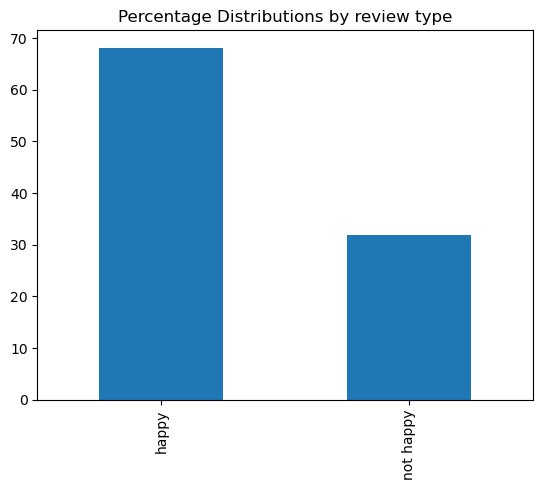

In [7]:
### Checking for the Distribution of Default ###


print('Percentage for default\n')
print(round(rivewdata.Is_Response.value_counts(normalize=True)*100,2))
round(rivewdata.Is_Response.value_counts(normalize=True)*100,2).plot(kind='bar')

plt.title('Percentage Distributions by review type')
plt.show()

In [8]:
rivewdata

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy
...,...,...,...,...,...
38927,id49253,We arrived late at night and walked in to a ch...,Edge,Desktop,happy
38928,id49254,The only positive impression is location and p...,InternetExplorer,Mobile,not happy
38929,id49255,Traveling with friends for shopping and a show...,Firefox,Mobile,not happy
38930,id49256,The experience was just ok. We paid extra for ...,Chrome,Desktop,not happy


In [9]:
#Removing columns

rivewdata.drop(columns = ['User_ID', 'Browser_Used', 'Device_Used'], inplace = True)

In [10]:
rivewdata

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,not happy
1,I stayed at the Crown Plaza April -- - April -...,not happy
2,I booked this hotel through Hotwire at the low...,not happy
3,Stayed here with husband and sons on the way t...,happy
4,My girlfriends and I stayed here to celebrate ...,not happy
...,...,...
38927,We arrived late at night and walked in to a ch...,happy
38928,The only positive impression is location and p...,not happy
38929,Traveling with friends for shopping and a show...,not happy
38930,The experience was just ok. We paid extra for ...,not happy


# Model training

In [11]:
# Apply first level cleaning

import re
import string

#This function converts to lower-case, removes square bracket, removes numbers and punctuation
def text_clean_1(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

cleaned1 = lambda x: text_clean_1(x)

In [12]:
# Let's take a look at the updated text

rivewdata['cleaned_description'] = pd.DataFrame(rivewdata.Description.apply(cleaned1))

rivewdata.head(10)

,Description,Is_Response,cleaned_description
0,The room was kind of clean but had a VERY stro...,not happy,the room was kind of clean but had a very stro...
1,I stayed at the Crown Plaza April -- - April -...,not happy,i stayed at the crown plaza april april th...
2,I booked this hotel through Hotwire at the low...,not happy,i booked this hotel through hotwire at the low...
3,Stayed here with husband and sons on the way t...,happy,stayed here with husband and sons on the way t...
4,My girlfriends and I stayed here to celebrate ...,not happy,my girlfriends and i stayed here to celebrate ...
5,We had - rooms. One was very nice and clearly ...,happy,we had rooms one was very nice and clearly ha...
6,My husband and I have stayed in this hotel a f...,not happy,my husband and i have stayed in this hotel a f...
7,My wife & I stayed in this glorious city a whi...,happy,my wife i stayed in this glorious city a whil...
8,My boyfriend and I stayed at the Fairmont on a...,happy,my boyfriend and i stayed at the fairmont on a...
9,"Wonderful staff, great location, but it was de...",not happy,wonderful staff great location but it was defi...


In [13]:
# Apply a second round of cleaning
def text_clean_2(text):
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

cleaned2 = lambda x: text_clean_2(x)

In [14]:
# Let's take a look at the updated text

rivewdata['cleaned_description_new'] = pd.DataFrame(rivewdata['cleaned_description'].apply(cleaned2))
rivewdata.head(10)

,Description,Is_Response,cleaned_description,cleaned_description_new
0,The room was kind of clean but had a VERY stro...,not happy,the room was kind of clean but had a very stro...,the room was kind of clean but had a very stro...
1,I stayed at the Crown Plaza April -- - April -...,not happy,i stayed at the crown plaza april april th...,i stayed at the crown plaza april april th...
2,I booked this hotel through Hotwire at the low...,not happy,i booked this hotel through hotwire at the low...,i booked this hotel through hotwire at the low...
3,Stayed here with husband and sons on the way t...,happy,stayed here with husband and sons on the way t...,stayed here with husband and sons on the way t...
4,My girlfriends and I stayed here to celebrate ...,not happy,my girlfriends and i stayed here to celebrate ...,my girlfriends and i stayed here to celebrate ...
5,We had - rooms. One was very nice and clearly ...,happy,we had rooms one was very nice and clearly ha...,we had rooms one was very nice and clearly ha...
6,My husband and I have stayed in this hotel a f...,not happy,my husband and i have stayed in this hotel a f...,my husband and i have stayed in this hotel a f...
7,My wife & I stayed in this glorious city a whi...,happy,my wife i stayed in this glorious city a whil...,my wife i stayed in this glorious city a whil...
8,My boyfriend and I stayed at the Fairmont on a...,happy,my boyfriend and i stayed at the fairmont on a...,my boyfriend and i stayed at the fairmont on a...
9,"Wonderful staff, great location, but it was de...",not happy,wonderful staff great location but it was defi...,wonderful staff great location but it was defi...


In [15]:
from sklearn.model_selection import train_test_split

Id=rivewdata.cleaned_description_new
de=rivewdata.Is_Response
i_train,i_test,d_train,d_test=train_test_split(Id,de,test_size=0.1,random_state=225)

print("i_train",len(i_train))
print("i_test",len(i_test))
print("d_train",len(d_train))
print("d_test",len(d_test))

i_train 35038
i_test 3894
d_train 35038
d_test 3894


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
tvec=TfidfVectorizer()
clf2=LogisticRegression(solver="lbfgs")

from sklearn.pipeline import Pipeline

In [17]:
model=Pipeline([('vectorizer',tvec),('Classifier',clf2)])
model.fit(i_train,d_train)
from sklearn.metrics import confusion_matrix
pred=model.predict(i_test)
confusion_matrix(pred,d_test)

array([[2418,  305],
       [ 153, 1018]], dtype=int64)

# Model prediciton

In [18]:
from sklearn.metrics import accuracy_score,precision_score,recall_score
print("accuracy",accuracy_score(pred,d_test))
print("precision",precision_score(pred,d_test,average='weighted'))
print("recall",recall_score(pred,d_test,average='weighted'))

accuracy 0.8823831535695943
precision 0.8890590818181386
recall 0.8823831535695943


# Trying on new reviews

In [19]:
example=["hii, i am satsfied and happy"]
result=model.predict(example)
print(result)

['happy']


In [20]:
example=["hii, i am stressed"]
result=model.predict(example)
print(result)

['not happy']


In [21]:
example=["hii, i am desheartened"]
result=model.predict(example)
print(result)

['not happy']


In [22]:
example=["I'm happy"]
result=model.predict(example)
print(result)

['happy']
